# Project 3
## *Instructions*

*Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can.*

*Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.*

*How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?*

## Import the Names Corpus

In [20]:
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
try:
    nltk.data.find('corpora/names')
except:
    nltk.download('names')

from nltk.corpus import names

## Feature Engineering Iteration 1: Vowel Proportion and Last Two Letters

Starting by creating a list of sets where each set is (name, gender) and then turning it into a pandas dataframe.

In [21]:
name_list = ([(name, 'male') for name in names.words('male.txt')] + [(name, 'female') for name in names.words('female.txt')])

names_df = pd.DataFrame(name_list, columns=['name','gender'])
names_df.head()

,name,gender
0,Aamir,male
1,Aaron,male
2,Abbey,male
3,Abbie,male
4,Abbot,male


Below we'll set up some functions to create features for our dataset. We generate the following features for each name:
- `vowel_proportion`: the proportion of vowels in the name,
- `first_last_letter`: the proportion of the first and last letters being vowels,
- `longest_run_of_vowels`: the length of the longest run of vowels in the name,
- `get_two_last_letters`: the last two letters of the name

In [22]:
# Create a feature that's the % of word that's vowels
def vowel_proportion(series: pd.Series) -> pd.Series:
    def _ratio(text):
        if not isinstance(text, str) or not text:
            return 0.0
        
        vowel_count = sum(1 for char in text.lower() if char in 'aeiou')
        
        return vowel_count / len(text)

    return series.apply(_ratio)

# Create a feature that's the % of the first and last letter being a vowel
def first_last_letter(series: pd.Series) -> pd.Series:
    def _check_ends(text):
        if not isinstance(text, str) or not text:
            return 0.0
            
        text_lower = text.lower()
        vowels = 'aeiou'
        vowel_endpoints = 0
        
        # Check first letter (index 0)
        if len(text_lower) >= 1 and text_lower[0] in vowels:
            vowel_endpoints += 1
            
        # Check last letter (index -1), but only if length is > 1 
        # to avoid double-counting the single character
        if len(text_lower) > 1 and text_lower[-1] in vowels:
            vowel_endpoints += 1
            
        # Proportion is always out of 2 possible positions
        return vowel_endpoints / 2.0

    return series.apply(_check_ends)

# Return an integer of the longest number of vowels in a name
def longest_run_of_vowels(series: pd.Series) -> pd.Series:
    def _max_run(text):
        if not isinstance(text, str):
            return 0
        
        text_lower = text.lower()
        vowels = 'aeiou'
        max_run = 0
        current_run = 0
        
        for char in text_lower:
            if char in vowels:
                current_run += 1
            else:
                # Vowel run is broken, check if it was the longest
                max_run = max(max_run, current_run)
                current_run = 0
                
        # Final check in case the string ends with a vowel run
        return max(max_run, current_run)

    return series.apply(_max_run)

def get_two_last_letters(series: pd.Series) -> pd.Series:
    def _last_letter(text):
        if not isinstance(text, str) or not text:
            return ''
        return text[-2:].lower()
    return series.apply(_last_letter)

In [23]:
def get_gender_features(df: pd.DataFrame) -> pd.DataFrame:
    funciton_list = [
        vowel_proportion,
        first_last_letter,
        longest_run_of_vowels,
        get_two_last_letters
    ]

    # Iterate through each function and apply them to the dataset
    for func in funciton_list:
        feature_name = func.__name__
        df[feature_name] = func(df['name'])
    
    return df

feature_names_df = get_gender_features(names_df)

# Print counts
print(feature_names_df['gender'].value_counts())

# Print percentage
print(feature_names_df['gender'].value_counts(normalize=True) * 100)

feature_names_df.head()

gender
female    5001
male      2943
Name: count, dtype: int64
gender
female    62.953172
male      37.046828
Name: proportion, dtype: float64


,name,gender,vowel_proportion,first_last_letter,longest_run_of_vowels,get_two_last_letters
0,Aamir,male,0.6,0.5,2,ir
1,Aaron,male,0.6,0.5,2,on
2,Abbey,male,0.4,0.5,1,ey
3,Abbie,male,0.6,1.0,2,ie
4,Abbot,male,0.4,0.5,1,ot


From the above, we can see our dataset is fairly unbalanced with females making up about 63% of the names.

For these new numeric fields, we'll create histograms to visualize their distributions and color them based on gender.

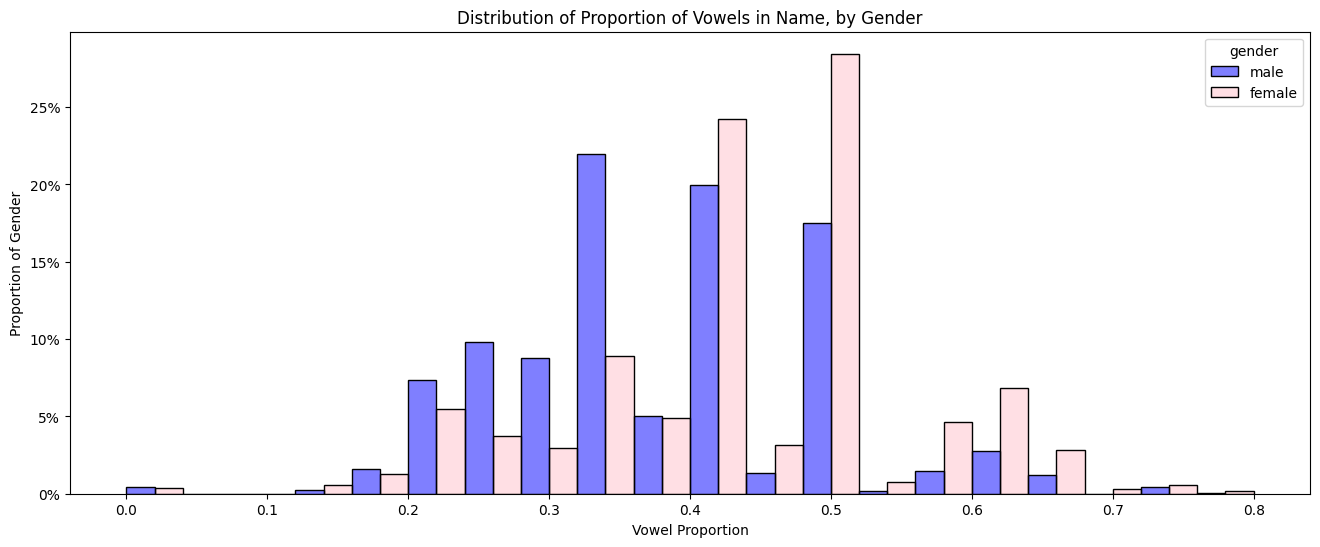

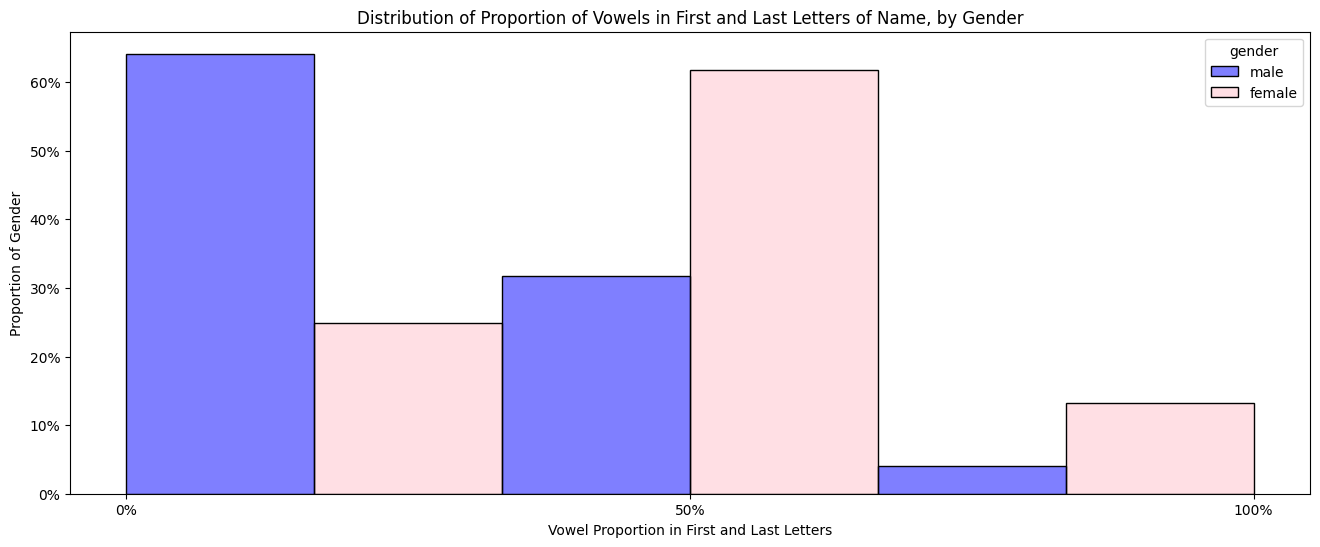

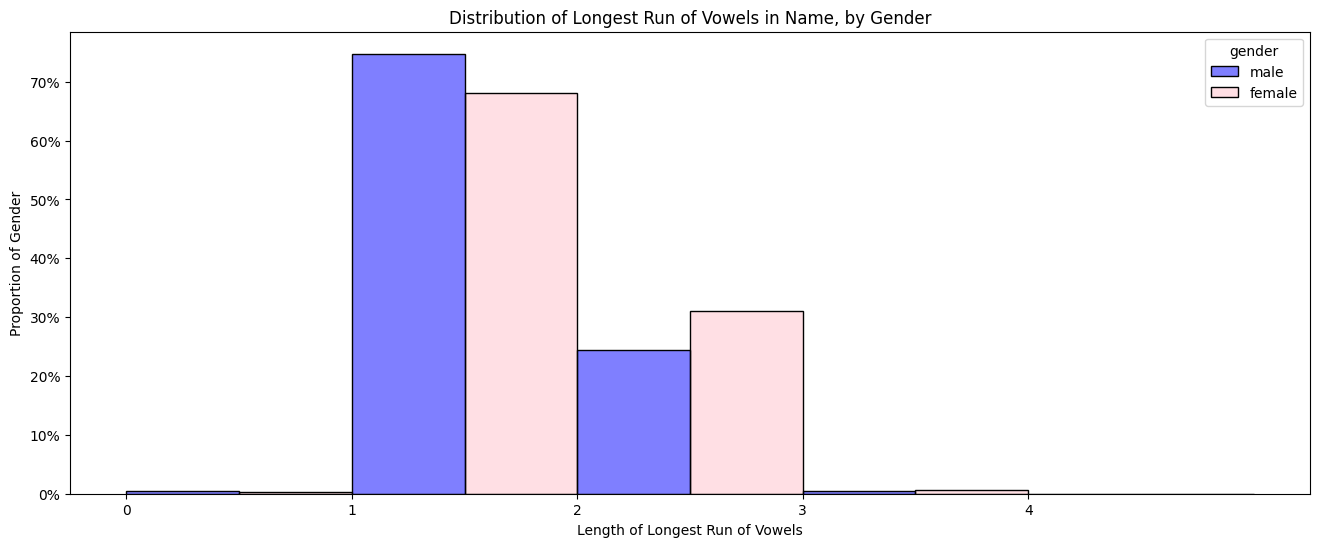

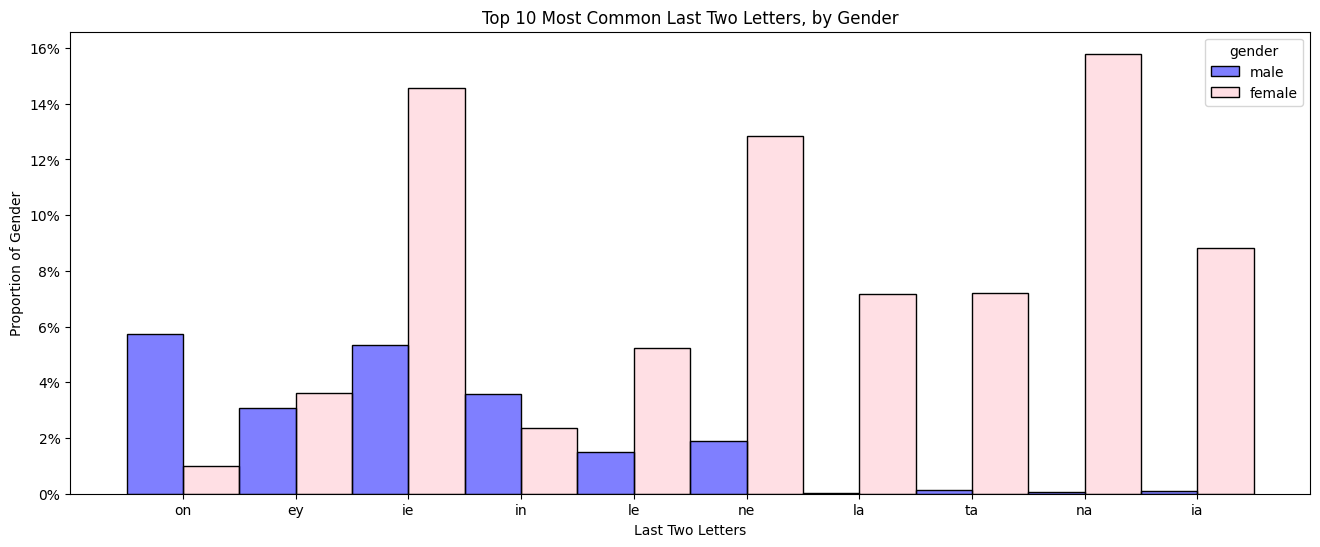

In [24]:
custom_palette = {'male': 'blue', 'female': 'pink'}

# Plot for vowel_proportion
plt.figure(figsize=(16, 6))
sns.histplot(
    data=feature_names_df,
    x='vowel_proportion',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    #kde=True,
    alpha=0.5,
    bins=20,
    common_norm=False,
    multiple='dodge'
)
plt.title('Distribution of Proportion of Vowels in Name, by Gender')
plt.xlabel('Vowel Proportion')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

# Plot for first_last_letter
plt.figure(figsize=(16, 6))
sns.histplot(
    data=feature_names_df,
    x='first_last_letter',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    #kde=True,
    alpha=0.5,
    bins=3,
    common_norm=False,
    multiple='dodge'
)
plt.xticks([0, 0.5, 1], ['0%', '50%', '100%'])
plt.title('Distribution of Proportion of Vowels in First and Last Letters of Name, by Gender')
plt.xlabel('Vowel Proportion in First and Last Letters')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

# Plot for longest_run_of_vowels
plt.figure(figsize=(16, 6))
sns.histplot(
    data=feature_names_df,
    x='longest_run_of_vowels',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    #kde=True,
    alpha=0.5,
    bins=range(int(feature_names_df['longest_run_of_vowels'].min()), int(feature_names_df['longest_run_of_vowels'].max()) + 2),
    common_norm=False,
    multiple='dodge'
)
plt.title('Distribution of Longest Run of Vowels in Name, by Gender')
plt.xlabel('Length of Longest Run of Vowels')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(
    range(
        int(feature_names_df['longest_run_of_vowels'].min()),
        int(feature_names_df['longest_run_of_vowels'].max()) + 1
    )
)
plt.show()

# Plot for get_two_last_letters
plt.figure(figsize=(16, 6))
top_10 = feature_names_df['get_two_last_letters'].value_counts().nlargest(10).index
sns.histplot(
    data=feature_names_df[feature_names_df['get_two_last_letters'].isin(top_10)],
    x='get_two_last_letters',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    alpha=0.5,
    multiple='dodge'
)
plt.title('Top 10 Most Common Last Two Letters, by Gender')
plt.xlabel('Last Two Letters')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

From our above histograms we can see that there is a slight difference in the distributions of vowel proportions and in the first and last letter. Although the longest run of vowels does not seem to differ much between genders.

Additionally, see that certain two-letter name endings are common with girls than with boys (e.g., "la", "ta", "na", and "ia") and vice versa (e.g., "on" and "in").

## Splitting our data

For our project, we'll split our data into a training and test dataset and balance the data so that there are equal numbers of male and female names. We split data into 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set.

In [25]:
def split_data_for_nltk(df, verbose=True):
    # I turned this into a function because we're going to be doing this more and more
    x = df.drop('gender', axis=1)
    y = df['gender']

    # Split into test (500), dev-test (500), and training (remaining)
    # Stratify to keep gender balance
    x_temp, x_test, y_temp, y_test = train_test_split(
        x, y, test_size=500, random_state=1, stratify=y
    )
    x_train, x_devtest, y_train, y_devtest = train_test_split(
        x_temp, y_temp, test_size=500, random_state=1, stratify=y_temp
    )

    # Print a summary of the split data (only if verbose=True)
    if verbose:
        print("\n--- Distribution after Stratified Split ---")
        print("Training set size:", len(y_train))
        print("Dev-test set size:", len(y_devtest))
        print("Test set size:", len(y_test))
        print("\nTraining set counts:", Counter(y_train))
        print("Dev-test set counts:", Counter(y_devtest))
        print("Test set counts:", Counter(y_test))

    rus = RandomUnderSampler(random_state=1)

    # Apply the sampling only to the training set
    x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

    # Print a summary of the final data (only if verbose=True)
    if verbose:
        print("\n--- Distribution after Undersampling Training Set ---")
        print("New (Balanced) Training set counts:", Counter(y_train_resampled))
        print(f"Total balanced training samples: {len(y_train_resampled)}")
        print("\nDev-test and Test sets (Unmodified for evaluation):")
        print("Dev-test set counts:", Counter(y_devtest))
        print("Test set counts:", Counter(y_test))
    
    # Return all three sets including dev-test
    return x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test

x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test = split_data_for_nltk(names_df)


--- Distribution after Stratified Split ---
Training set size: 6944
Dev-test set size: 500
Test set size: 500

Training set counts: Counter({'female': 4371, 'male': 2573})
Dev-test set counts: Counter({'female': 315, 'male': 185})
Test set counts: Counter({'female': 315, 'male': 185})

--- Distribution after Undersampling Training Set ---
New (Balanced) Training set counts: Counter({'female': 2573, 'male': 2573})
Total balanced training samples: 5146

Dev-test and Test sets (Unmodified for evaluation):
Dev-test set counts: Counter({'female': 315, 'male': 185})
Test set counts: Counter({'female': 315, 'male': 185})


With our datasets prepared, we'll need to convert it into the format expected by NLTK classifiers, which is a list of tuples where each tuple is (feature_dict, label)

In [26]:
def prepare_data_for_nltk(X_df, y_series):
    """Converts Pandas DataFrame/Series to NLTK's required list of (dict, label) tuples."""
    # Convert feature rows into a list of feature dictionaries
    feature_dicts = X_df.to_dict(orient='records')
    # Zip the feature dictionaries with the corresponding labels
    nltk_set = list(zip(feature_dicts, y_series))
    return nltk_set

test_nltk_data = prepare_data_for_nltk(x_test, y_test)  # Save for final evaluation
train_nltk_data = prepare_data_for_nltk(x_train_resampled, y_train_resampled)
devtest_nltk_data = prepare_data_for_nltk(x_devtest, y_devtest)  

## Building our models

We'll try the following three models:
1. Naive Bayes Classifier
2. Decision Tree Classifier
3. Maxent Classifier

In [27]:
def train_nltk_classifiers(training_data):
    # I turned this into a function since we'll be iterating
    return(
        {
            'NaiveBayes': nltk.NaiveBayesClassifier.train(training_data),
            'DecisionTree': nltk.DecisionTreeClassifier.train(training_data),
            'MaxentClassifier': nltk.MaxentClassifier.train(training_data, max_iter=10, trace=0)
        }
    )

first_round_bathroom_classifiers = train_nltk_classifiers(train_nltk_data)

print("\n--- Evaluating on dev-test set ---")
for name, classifier in first_round_bathroom_classifiers.items():
    accuracy = nltk.classify.accuracy(classifier, devtest_nltk_data)
    print(f"{name} Dev-Test Accuracy: {accuracy * 100:.2f}%")


--- Evaluating on dev-test set ---
NaiveBayes Dev-Test Accuracy: 75.20%
DecisionTree Dev-Test Accuracy: 34.20%
MaxentClassifier Dev-Test Accuracy: 74.60%


On the first round of models with our feature we find that the Naive Bayes classifier is the best performing with an accuracy of 75.2%.

In [28]:
first_round_bathroom_classifiers['NaiveBayes'].show_most_informative_features(50)

Most Informative Features
    get_two_last_letters = 'na'           female : male   =     90.6 : 1.0
    get_two_last_letters = 'la'           female : male   =     69.0 : 1.0
    get_two_last_letters = 'ia'           female : male   =     52.6 : 1.0
    get_two_last_letters = 'us'             male : female =     36.3 : 1.0
    get_two_last_letters = 'sa'           female : male   =     33.7 : 1.0
    get_two_last_letters = 'ra'           female : male   =     23.6 : 1.0
    get_two_last_letters = 'rd'             male : female =     23.0 : 1.0
    get_two_last_letters = 'ta'           female : male   =     21.4 : 1.0
    get_two_last_letters = 'ld'             male : female =     18.3 : 1.0
    get_two_last_letters = 'do'             male : female =     16.3 : 1.0
    get_two_last_letters = 'io'             male : female =     15.0 : 1.0
    get_two_last_letters = 'ka'           female : male   =     12.3 : 1.0
    get_two_last_letters = 'os'             male : female =     12.3 : 1.0

Looking at the most important 20 features we can see that they're all related to the last two letters of the name. Extending the importance further to 50 features, we found that a vowel proportion of 62.5% also appear in the list.
    
To further improve our model, we can likely engineer more features related to the letters in the names.

## Feature Engineering Iteration 2: First Letter, Name Length, and Longest Consonant Chain
First we saw that the numeric columns we assumed might be useful weren't very informative and thus decided to drop them from our feature set.

In [29]:
iteration_2_df = feature_names_df.drop(columns = ['vowel_proportion', 'first_last_letter', 'longest_run_of_vowels'], errors='ignore')
iteration_2_df.head()

,name,gender,get_two_last_letters
0,Aamir,male,ir
1,Aaron,male,on
2,Abbey,male,ey
3,Abbie,male,ie
4,Abbot,male,ot


For a new set of features, we'll use the first letter of the word and we'll also add in the length of the name as a feature. For the new numeric value, we'll also plot a histogram as we did before.

In [41]:
iteration_2_df['name_length'] = iteration_2_df['name'].apply(len)
iteration_2_df['first_letter'] = iteration_2_df['name'].str[0].str.lower()
iteration_2_df.head()

,name,gender,get_two_last_letters,first_letter,name_length
0,Aamir,male,ir,a,5
1,Aaron,male,on,a,5
2,Abbey,male,ey,a,5
3,Abbie,male,ie,a,5
4,Abbot,male,ot,a,5


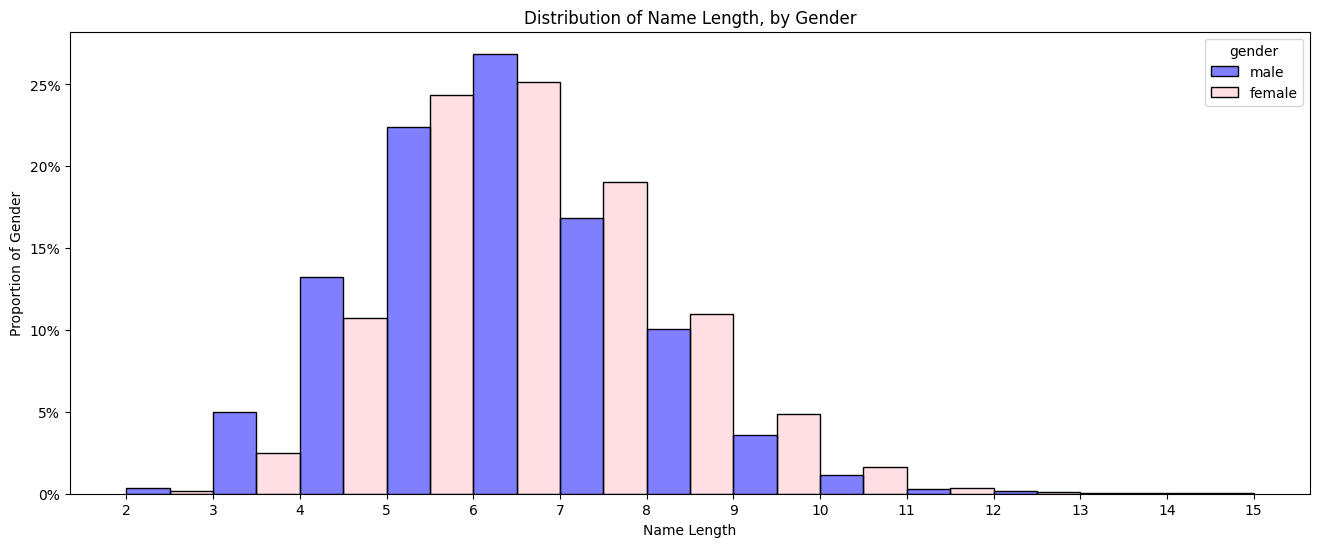

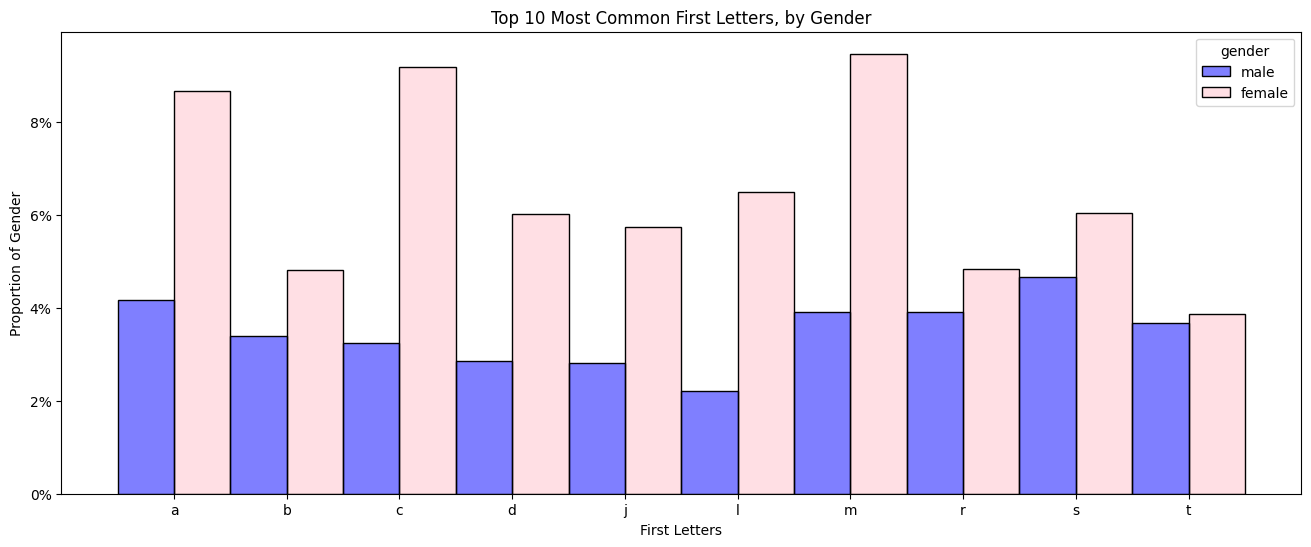

In [42]:
plt.figure(figsize=(16, 6))

sns.histplot(
    data=iteration_2_df,
    x='name_length',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    multiple='dodge',
    #kde=True,
    alpha=0.5,
    bins=13,
    common_norm=False
)
plt.title('Distribution of Name Length, by Gender')
plt.xlabel('Name Length')
plt.xticks(range(iteration_2_df['name_length'].min(), iteration_2_df['name_length'].max() + 1))
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

# Plot for first_letter
plt.figure(figsize=(16, 6))
top_10 = iteration_2_df['first_letter'].value_counts().nlargest(10).index
sns.histplot(
    data=iteration_2_df[iteration_2_df['first_letter'].isin(top_10)],
    x='first_letter',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    alpha=0.5,
    multiple='dodge'
)
plt.title('Top 10 Most Common First Letters, by Gender')
plt.xlabel('First Letters')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.show()

Name length doesn't seem to provide any information so we'll drop it from our dataset. The first letter seems to have some differences between gender so we'll keep it as a feature.

In [32]:
iteration_2_df = iteration_2_df.drop(columns=['name_length'], errors='ignore')
iteration_2_df.head()

,name,gender,get_two_last_letters,first_letter
0,Aamir,male,ir,a
1,Aaron,male,on,a
2,Abbey,male,ey,a
3,Abbie,male,ie,a
4,Abbot,male,ot,a


In the spirit of trying something new, let's get the longest consonant chain.

In [33]:
def gimme_the_longest_consonant_chain(name: pd.Series) -> pd.Series:
    if not isinstance(name, str):
        return '' # Return empty string for non-string input
    
    consonants = set('bcdfghjklmnpqrstvwxyz')
    name_lower = name.lower()
    
    max_chain_str = ""
    current_chain_str = ""
    
    for char in name_lower:
        if char.isalpha() and char in consonants:
            # Character is a consonant, append it to the current chain string
            current_chain_str += char
        else:
            # Character is a vowel, 'y', or non-alphabetic
            # Check if the current chain is the longest found so far
            if len(current_chain_str) > len(max_chain_str):
                max_chain_str = current_chain_str
            # Reset the current chain string
            current_chain_str = ""
            
    # Important: Check one last time after the loop finishes 
    # (in case the longest chain ends the string)
    if len(current_chain_str) > len(max_chain_str):
        max_chain_str = current_chain_str

    return max_chain_str

iteration_3_df = iteration_2_df.copy()
iteration_3_df['longest_consonant_chain'] = iteration_3_df['name'].apply(gimme_the_longest_consonant_chain)
iteration_3_df.head()


,name,gender,get_two_last_letters,first_letter,longest_consonant_chain
0,Aamir,male,ir,a,m
1,Aaron,male,on,a,r
2,Abbey,male,ey,a,bb
3,Abbie,male,ie,a,bb
4,Abbot,male,ot,a,bb


We plot this below.

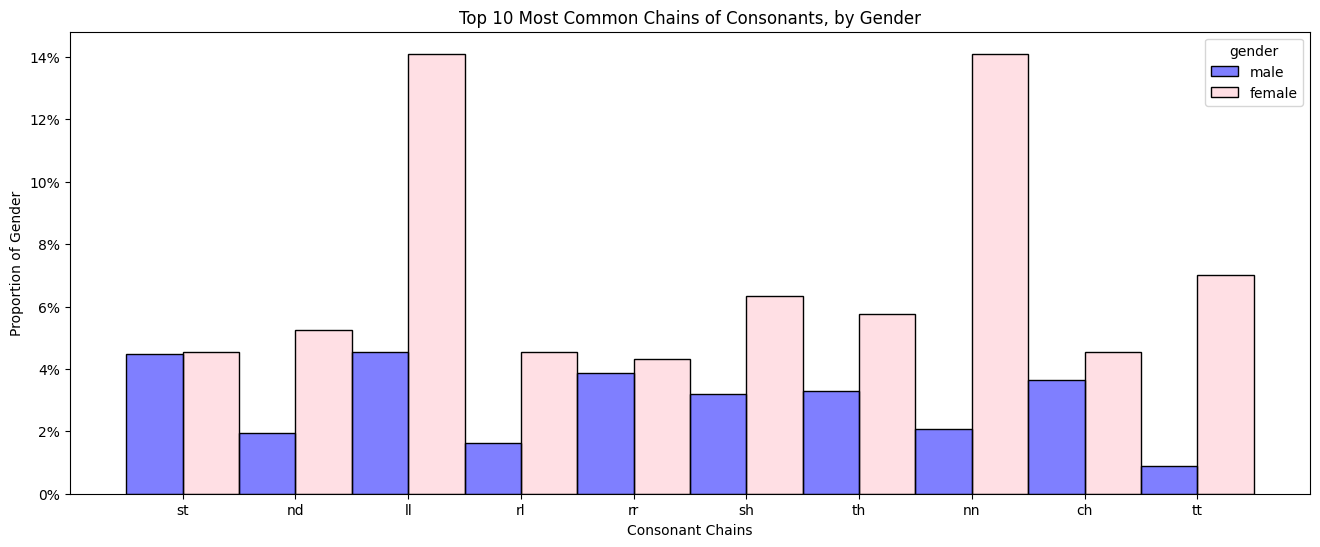

In [37]:
# Plot for longest_consonant_chain
plt.figure(figsize=(16, 6))
top_10 = iteration_3_df[iteration_3_df['longest_consonant_chain'].str.len() > 1]['longest_consonant_chain'].value_counts().nlargest(10).index
sns.histplot(
    data=iteration_3_df[iteration_3_df['longest_consonant_chain'].isin(top_10)],
    x='longest_consonant_chain',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    alpha=0.5,
    multiple='dodge'
)
plt.title('Top 10 Most Common Chains of Consonants, by Gender')
plt.xlabel('Consonant Chains')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

There appear to be a high proportion of girls names with two "l"s or "n"s in a row. 

With these new features, we'll try classifying the names again and see how well the models perform.

In [35]:
# We'll define a new function to just pass the dataframe and do all of the previous steps
def dataframe_to_classifiers(df, training_cycle_name):
    # Split the data (suppress verbose output)
    x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test = split_data_for_nltk(df, verbose=False)
    
    # Convert to NLTK format
    train_nltk_data = prepare_data_for_nltk(x_train_resampled, y_train_resampled)
    devtest_nltk_data = prepare_data_for_nltk(x_devtest, y_devtest)
    test_nltk_data = prepare_data_for_nltk(x_test, y_test)

    # Train all three classifiers with the new features
    classifiers = train_nltk_classifiers(train_nltk_data)
    
    print(f"\n--- Results for {training_cycle_name} (on DEV-TEST set) ---")

    best_classifier = None
    best_classifier_name = None
    best_accuracy = 0

    # Evaluate each classifier on dev-test set
    for name, classifier in classifiers.items():
        accuracy = nltk.classify.accuracy(classifier, devtest_nltk_data)
        print(f"{name} Dev-Test Accuracy: {accuracy * 100:.2f}%")
        
        if accuracy > best_accuracy:
            best_classifier = classifier
            best_classifier_name = name
            best_accuracy = accuracy

    print(f"\nThe best classifier is {best_classifier_name} with a dev-test accuracy of {best_accuracy * 100:.2f}%\n")
    best_classifier.show_most_informative_features(20)
    
    return test_nltk_data, best_classifier

# Run iteration 3 with new features
test_data_final, best_classifier = dataframe_to_classifiers(iteration_3_df, "Last Two Letters, First Letter, & Longest Consonant Chain")


--- Results for Last Two Letters, First Letter, & Longest Consonant Chain (on DEV-TEST set) ---
NaiveBayes Dev-Test Accuracy: 79.60%
DecisionTree Dev-Test Accuracy: 34.20%
MaxentClassifier Dev-Test Accuracy: 78.00%

The best classifier is NaiveBayes with a dev-test accuracy of 79.60%

Most Informative Features
    get_two_last_letters = 'na'           female : male   =     90.6 : 1.0
    get_two_last_letters = 'la'           female : male   =     69.0 : 1.0
    get_two_last_letters = 'ia'           female : male   =     52.6 : 1.0
    get_two_last_letters = 'us'             male : female =     36.3 : 1.0
    get_two_last_letters = 'sa'           female : male   =     33.7 : 1.0
    get_two_last_letters = 'ra'           female : male   =     23.6 : 1.0
    get_two_last_letters = 'rd'             male : female =     23.0 : 1.0
    get_two_last_letters = 'ta'           female : male   =     21.4 : 1.0
    get_two_last_letters = 'ld'             male : female =     18.3 : 1.0
    get_two_

The Naive Bayes Classifier remains the best model choice, performing slightly better than our first model with a minor improvement in accuracy from correctly predicting 75.2% of genders in the test set to 79.6%. The last 2 letters remain the most informative feature in the data, but we can now see that consonant runs like "rv", "rk", and "lt" are important for predicting male names, and "lyn" can help predict female names.

## Final Evaluation on Test Set

Now that we're satisfied with our best model from the two dev test iterations, we evaluate it on the held-out test set to get a final estimate of "real-world" performance.

In [36]:
# Final evaluation on the test set
# Accuracy baased on dev-test set (same what's reported above)
devtest_accuracy = nltk.classify.accuracy(best_classifier, devtest_nltk_data)
print(f"\nDev-Test Accuracy: {devtest_accuracy * 100:.2f}%")

# Accuracy based on test set
test_accuracy = nltk.classify.accuracy(best_classifier, test_data_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Compare the two
difference = test_accuracy - devtest_accuracy
print(f"\nDifference (Test - Dev-Test): {difference * 100:.2f} percentage points")


Dev-Test Accuracy: 78.20%
Test Accuracy: 79.60%

Difference (Test - Dev-Test): 1.40 percentage points


The dev-test and test accuracy are similar--within 1.4 percentage points of eachother--indicating that our model generalizes well and is not overfitted. This is in line with our expectations.